# Signal processing



OpenSoundscape provides a set of signal processing tools developed in house. In this notebook we provide a comparison of two of these tools on a published bioacoustics dataset.

* RIBBIT (Repeat-Interval Based Bioacoustic Identification Tool) is a tool for detecting vocalizations that have a repeating structure. This tool is useful for detecting vocalizations of frogs, toads, and other animals that produce vocalizations with a periodic structure. RIBBIT is also [available as an R package](https://github.com/kitzeslab/r-ribbit). 

    Published here: [Automated detection of frog calls and choruses by pulse repetition rate](https://doi.org/10.1111/cobi.13718)
    
* Continuous wavelet transform

    Published here: [Automated recognition of ruffed grouse drumming in field recordings](https://doi.org/10.1002/wsb.1395)
    

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/signal_processing.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/signal_processing.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0

## Setup 

### Import required packages

In [2]:
# Data handling and plotting
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from pathlib import Path
from sklearn.metrics import precision_score, recall_score

# figures
import IPython.display as ipd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10,3] # spectrogram / figure size - adjust for your display
%config InlineBackend.figure_format = 'retina'

# Audio handling
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

# Signal processing
from opensoundscape.ribbit import ribbit
from opensoundscape.signal_processing import detect_peak_sequence_cwt

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Download data

We choose one particular bird species Northern Flicker (Colaptes auratus) that has a song conducive to analysis by the signal processing methods. 

Run the cells below to download the sample clips for this analysis: have already been provided been with the demo repository [demos-for-opso](https://github.com/kitzeslab/demos-for-opso) in the `data` folder.

In [3]:
!mkdir signal_processing_examples
!cd signal_processing_examples && curl 'https://raw.githubusercontent.com/kitzeslab/demos-for-opso/main/resources/04/nofl_keek_labels_df.csv' -sLo 'nofl_keek_labels_df.csv'
!cd signal_processing_examples && curl 'https://raw.githubusercontent.com/kitzeslab/demos-for-opso/main/resources/04/nofl_keek_df.csv' -sLo 'nofl_keek_df.csv'
!mkdir signal_processing_examples/clips
!cd signal_processing_examples/clips && curl 'https://github.com/kitzeslab/demos-for-opso/raw/main/resources/04/clips/Recording_1_Segment_23.mp3' -sLo 'Recording_1_Segment_23.mp3'
!cd signal_processing_examples/clips && curl 'https://github.com/kitzeslab/demos-for-opso/raw/main/resources/04/clips/Recording_1_Segment_29.mp3' -sLo 'Recording_1_Segment_29.mp3'
!cd signal_processing_examples/clips && curl 'https://github.com/kitzeslab/demos-for-opso/raw/main/resources/04/clips/Recording_2_Segment_09.mp3' -sLo 'Recording_2_Segment_09.mp3'
!cd signal_processing_examples/clips && curl 'https://github.com/kitzeslab/demos-for-opso/raw/main/resources/04/clips/Recording_4_Segment_21.mp3' -sLo 'Recording_4_Segment_21.mp3'
!cd signal_processing_examples/clips && curl 'https://github.com/kitzeslab/demos-for-opso/raw/main/resources/04/clips/XC645833%20-%20Northern%20Flicker%20-%20Colaptes%20auratus.mp3' -sLo 'XC645833 - Northern Flicker - Colaptes auratus.mp3'

In [4]:
# set the data path
data_path = './signal_processing_examples/'

Let us look at a particular type of song called 'keek' for this species which has a repeating sequence of shrill calls. The clip used to get a good idea of the song has been downloaded from [xeno-canto](https://xeno-canto.org), a website for sharing crowd-sourced recordings of wildlife sounds from all across the world.

The particular clip `XC645833 - Northern Flicker - Colaptes auratus.mp3` is from Ted Floyd, XC645833. Accessible at www.xeno-canto.org/645833.

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


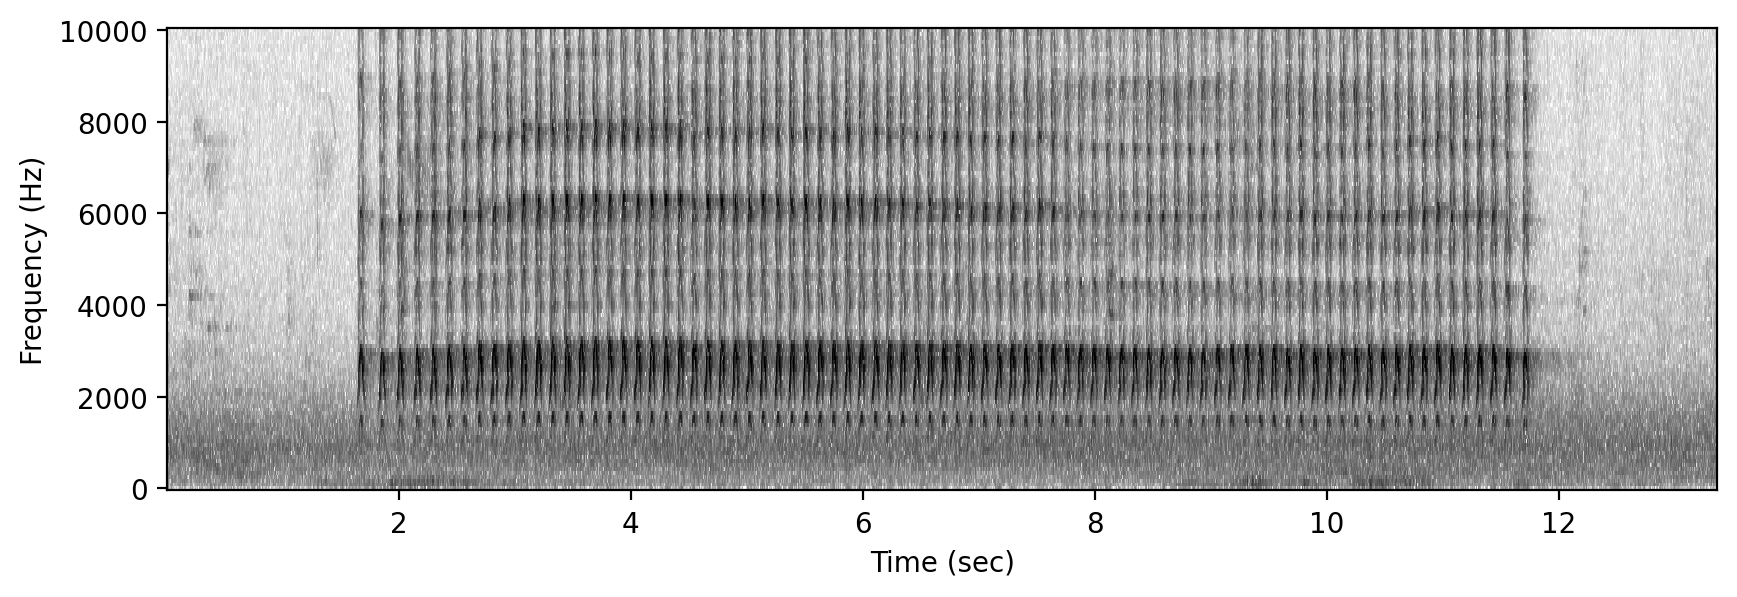

<Audio(samples=(589767,), sample_rate=44100)>

In [5]:
# load audio file and display it
nofl_keek_audio_xc = Audio.from_file(data_path + 'clips/XC645833 - Northern Flicker - Colaptes auratus.mp3')
Spectrogram.from_audio(nofl_keek_audio_xc).bandpass(0,10000).plot()
nofl_keek_audio_xc #can also show this widget with .show_widget()


For the analysis we utilize a bioacoustics dataset published by the Kitzes Lab, of Eastern North American birds, which comprises of 385 minutes of dawn chorus soundscapes for 48 species collected in the Northeastern United States at Powdermill Nature Reserve, Rector, Pennsylvania, USA through autonomous acoustic recorders between the months of April through July 2018. Each of the soundscape recording in this dataset is divided into five minutes long annotated segments. 

ref: [Chronister LM, Rhinehart TA, Place A, Kitzes J. An annotated set of audio recordings of Eastern North American birds containing frequency, time, and species information. Ecology. 2021 Jun;102(6):e03329. doi: 10.1002/ecy.3329. Epub 2021 May 11. PMID: 33705568.](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1002/ecy.3329)

We choose four of these annotated segments for our analysis since they are labeled to contain the most number of NOFL calls. The corresponding Raven annotations have been loaded and filtered using OpSo `annotations` and for the sake of this tutorial we have prepared a csv of the audio we'll be testing our signal processing methods on.

In [6]:
data_path

'./signal_processing_examples/'

In [7]:
# load annotations
nofl_keek_df = pd.read_csv(data_path+'nofl_keek_df.csv')

# corret the location of audio files to match where we saved them 
nofl_keek_df['audio_file'] = [data_path + 'clips' + f.split('/clips')[-1] for f in nofl_keek_df['audio_file']]
nofl_keek_df.head(2)

,audio_file,start_time,end_time,low_f,high_f,annotation
0,./signal_processing_examples/clips/Recording_1...,17.219173,19.750294,2482.6,3499.1,keek
1,./signal_processing_examples/clips/Recording_1...,100.463319,104.715601,2595.3,3570.9,keek


Let's convert the annotations into 0/1 labels for each 10 second segment of audio

We'll consider an annotation to be part of a 10 second clip if it overlaps with the clip by at least 1 second.

In [8]:
from opensoundscape.annotations import BoxedAnnotations
ba = BoxedAnnotations(df=nofl_keek_df,audio_files=nofl_keek_df['audio_file'].values)
labels_10s = ba.clip_labels(clip_duration=10,clip_overlap=0,min_label_overlap=1)
#labels_10s.columns=['label']
labels_10s.head()

keek
file                                               start_time end_time       
./signal_processing_examples/clips/Recording_1_... 0.0        10.0      False
                                                   10.0       20.0       True
                                                   20.0       30.0      False
                                                   30.0       40.0      False
                                                   40.0       50.0      False

Let us look at one of these positive clips (a particularly hard example!) from our soundscape recordings.

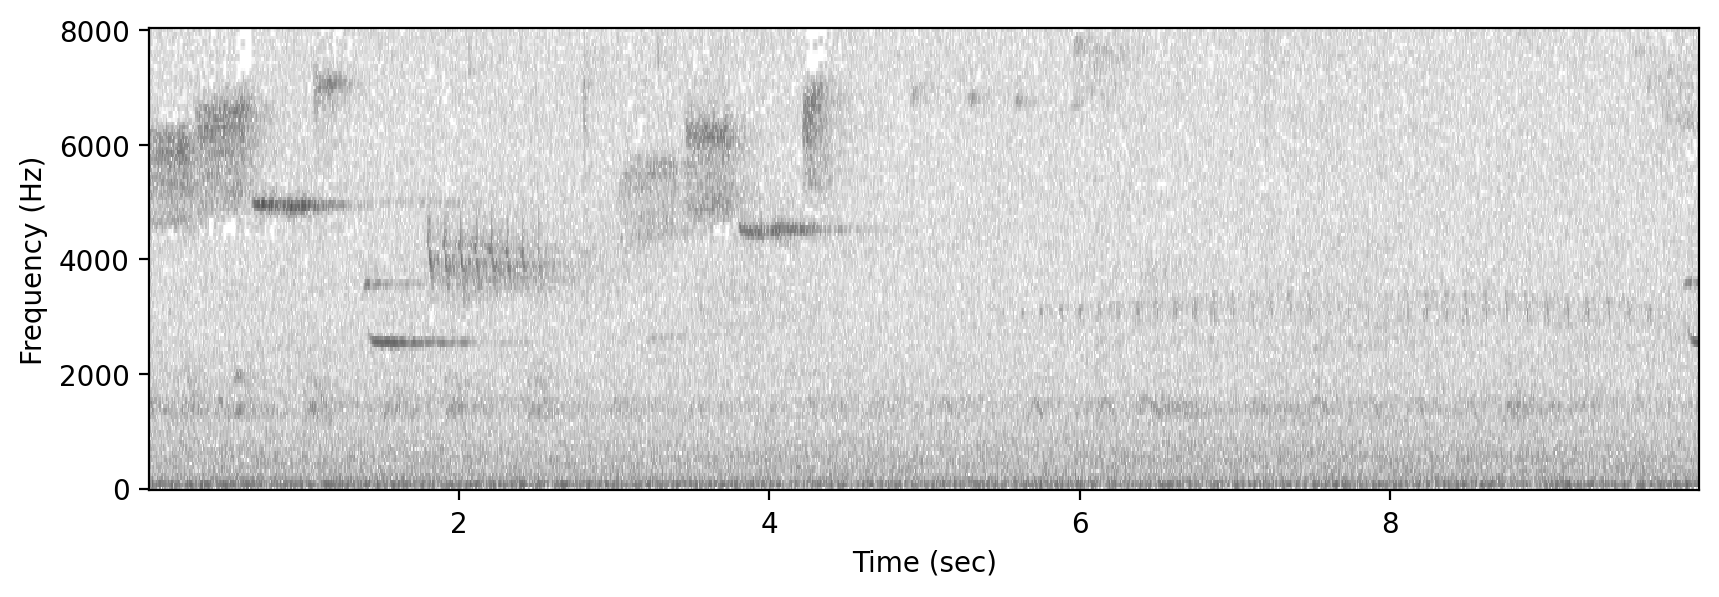

In [9]:
# audio
audio = Audio.from_file(f"{data_path}/clips/Recording_1_Segment_23.mp3",offset=95,duration=10)
audio.show_widget()
Spectrogram.from_audio(audio).bandpass(0,8000).plot()

The repeated keek call of the Northern Flicker is visible in the second half of the spectrogram, but it's much harder to pick out than the example from xeno-canto, as it's in amongst other calls in the soundscape and is more distant. We'll test two signal processing methods available in OpenSoundscape for their ability to detect these vocalizations. 

## RIBBIT method
The RIBBIT method detects sounds with periodic amplitude modulation, and was developed in [Lapp et al 2021](https://conbio.onlinelibrary.wiley.com/doi/full/10.1111/cobi.13718) to detect frog calls. Since the Northern Flicker keek sequence contains a regular structure of periodic amplitude modulation, we experiment with using RIBBIT to detect this vocalization. 

#### Model parameters

The method requires signal parameters to be set based on expected properties of the call as following.

In [10]:
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [4,15] 

# look for a vocalization in the frequency range  
signal_band = [2200,3500] 

# remove background noise based on these frequency ranges
noise_bands = [[0,1000]]

# divides the signal into segments this many seconds long, analyzes each independently
clip_duration = 10 # seconds
clip_overlap = 0 # seconds
final_clip = 'remainder' # how to handle the final clip if it is shorter than clip_duration

# if True, it will show the power spectrum plot for each audio segment 
show_plots = True 

#### Visualize RIBBIT analysis
To start with, we analyze the first few seconds of the xeno-canto file containing a Northern Flicker in the foreground. By using show_plots=True, we can see the power spectral density calculated by the RIBBIT method based on the parameters selected above. 

window: 0.0 to 9.996190476190476 sec


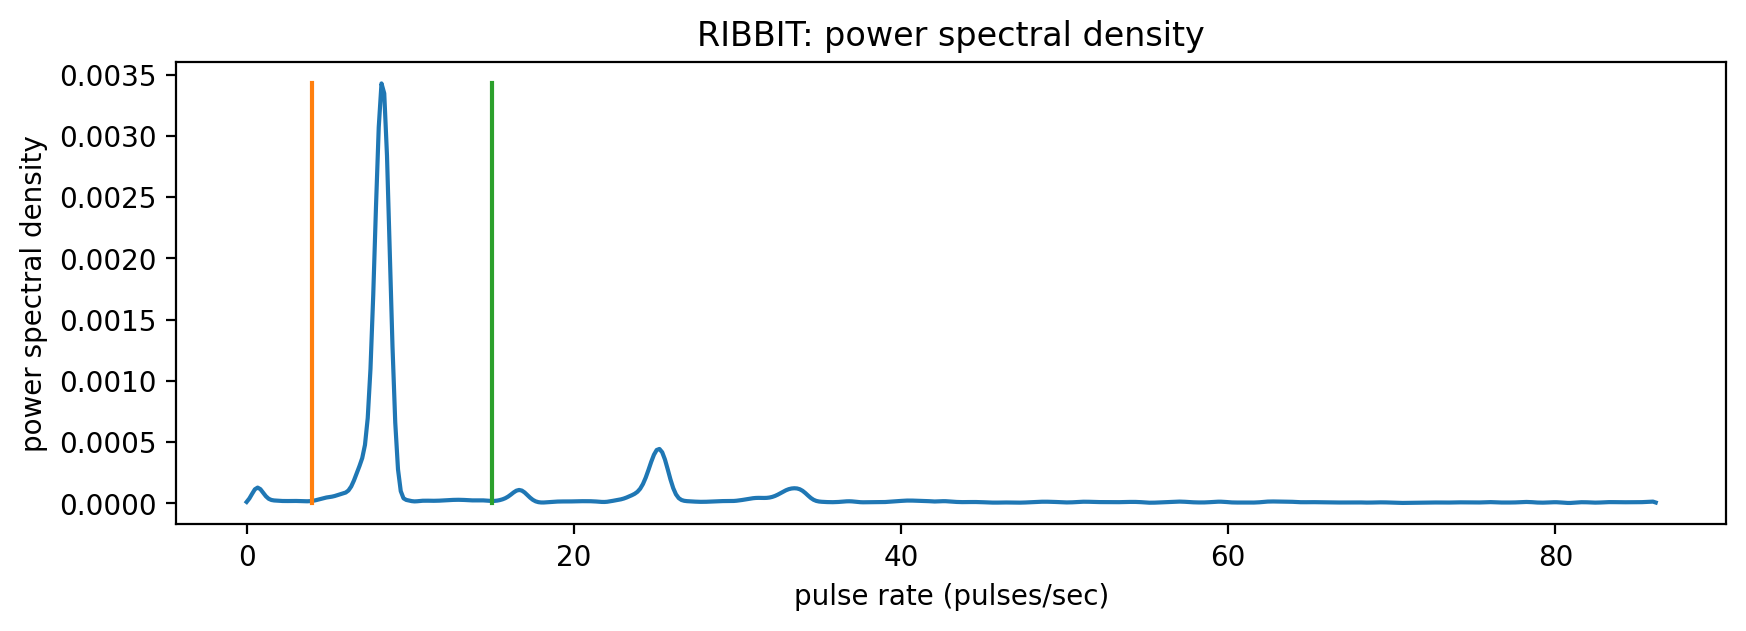

,start_time,end_time,score
0,0.0,9.99619,34.284912


In [11]:
# make a spectrogram
spec = Spectrogram.from_audio(nofl_keek_audio_xc.trim(0,10))

#run RIBBIT
score_df =  ribbit(
    spectrogram=spec,
    signal_band=signal_band,
    pulse_rate_range=pulse_rate_range,
    clip_duration=clip_duration,
    clip_overlap=clip_overlap,
    noise_bands=noise_bands,
    final_clip=final_clip,
    plot=show_plots,
)

score_df['score'] = score_df['score']*10000
score_df

The Northern Flicker's keek sequence is clearly visible in the power spectral density as a peak at 9 repetitions per second. 

The scores output by the RIBBIT method are the maximum value of the power spectral density within the `pulse_rate_range` denoted by the orang and green bounds on the plot. One score is generated for each analysis window of length `clip_duration`.

#### Evaluation

Now, let us look at the field clips we have from the annotated dataset. 

In [12]:
score_df_list = []

# calculate RIBBIT scores
files = labels_10s.reset_index()['file'].unique()

for file in files:
    
    # make the spectrogram
    spec = Spectrogram.from_audio(audio.from_file(file))

    #run RIBBIT
    score_df =  ribbit(
        spectrogram=spec,
        signal_band=signal_band,
        pulse_rate_range=pulse_rate_range,
        clip_duration=clip_duration,
        clip_overlap=clip_overlap,
        noise_bands=noise_bands,
        final_clip=final_clip,
        plot=False,
    )
    
    #add score to table
    score_df['score'] = score_df['score']*10000
    score_df['file'] = file
    score_df = score_df.reset_index(drop=True).set_index(['file', 'start_time', 'end_time'])
    score_df_list.append(score_df)

score_df = pd.concat(score_df_list).sort_index()

# add scores to label dataframe
labels_10s['ribbit_score'] = score_df.loc[labels_10s.index]['score']

In [13]:
labels_10s.head()

keek  \
file                                               start_time end_time          
./signal_processing_examples/clips/Recording_1_... 0.0        10.0      False   
                                                   10.0       20.0       True   
                                                   20.0       30.0      False   
                                                   30.0       40.0      False   
                                                   40.0       50.0      False   

                                                                        ribbit_score  
file                                               start_time end_time                
./signal_processing_examples/clips/Recording_1_... 0.0        10.0          0.014986  
                                                   10.0       20.0          0.386325  
                                                   20.0       30.0          0.391848  
                                                   30.0       40.0          0.016624  
                                                   40.0       50.0          0.000467

### Evaluate performance of the method 

In [14]:
print(f"Recall: {recall_score(labels_10s.keek.values,labels_10s.ribbit_score>0.5):0.2f}")
print(f"Precision: {precision_score(labels_10s.keek.values,labels_10s.ribbit_score>0.5):0.2f}")

Recall: 0.35
Precision: 0.88


The method detects roughly a third of the keek annotations with high precision. Low recall probably occurs because many of the keek annotations in the annotated dataset are very distant and are masked by other sounds. 

## Wavelet-based peak sequence method

This method, from [Lapp et al 2022](https://wildlife.onlinelibrary.wiley.com/doi/full/10.1002/wsb.1395), uses a continuous wavelet transform to extract sequences of constant-frequency syllables from audio. Then, it searches for sequences of extracted peaks matching a set of criteria: for instance, the spacing between peaks and the number of peaks in the sequence. 

Let's try it out for the Northern Flicker keek call as an alternative to the RIBBIT method. 

#### Parameters
The parameters for this method are based on arguments as given below. The associated manuscript describes parameters in detail.

In [15]:
sr = 8000 # resample audio to this sample rate
window_len = 10 # sec to analyze in one chunk
center_frequency = 3500 # target audio frequency of cwt
wavelet = 'morl' # pywt wavelet name - let's keep default for now
peak_threshold = 0.07 # height threhsold (0-1) for peaks in normalized signal
peak_separation = 1/15 # min duration (sec) between peaks when extracting peaks
dt_range = (1/15, 1/3) # range of peak separation (sec) to search for
dy_range = (-0.05, 0.05) # range of peak separation reduction rate
d2y_range = (-0.03, 0.03) # range of peak separation reduction rate of change
max_skip = 2 # max sequential invalid points
duration_range = (1, 10) # length (sec) of sequence
points_range = (10, 100) # number of points in sequence
show_plots = True # show plots of each segment

#### Visualize Method
Let's visualize the wavelet method, once again using the Xeno Canto recording of a foreground Northern Flicker. 


detected peaks and sequences for window 1


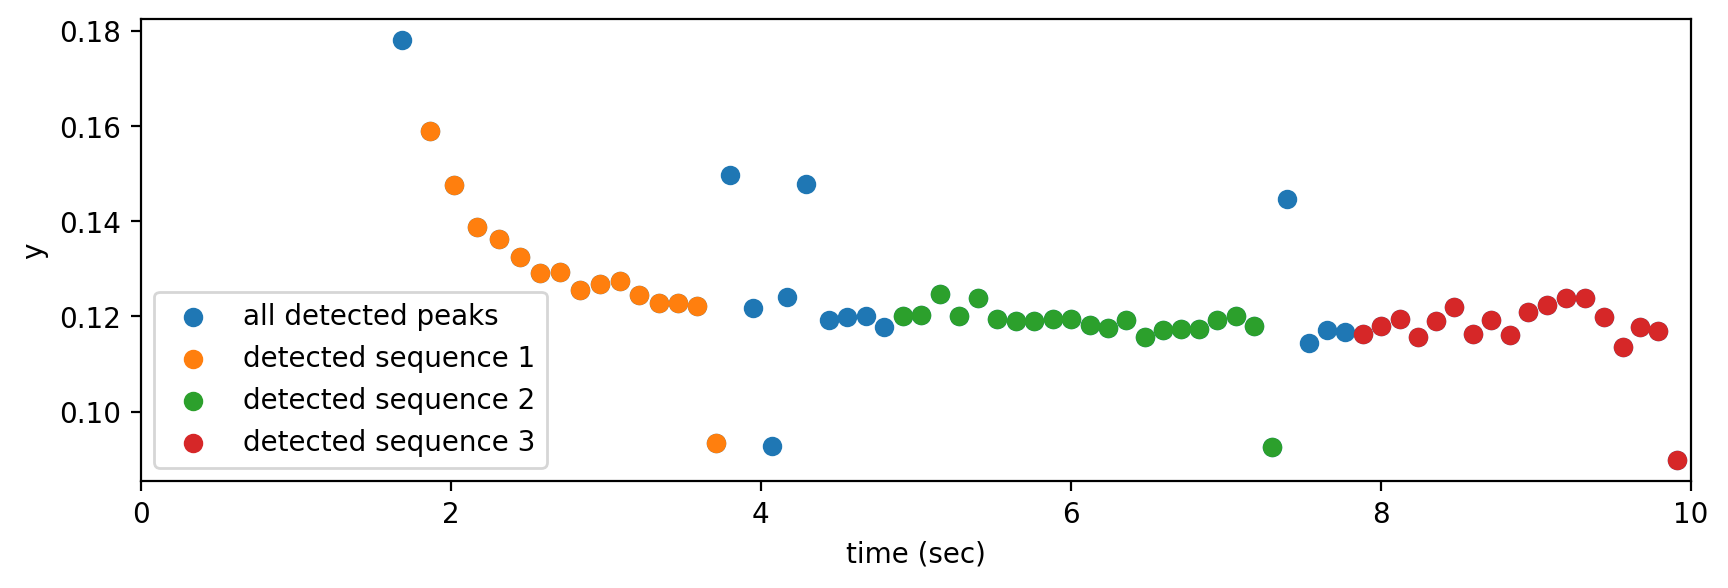

,sequence_y,sequence_t,window_start_t,seq_len,seq_start_time,seq_end_time,seq_midpoint_time
0,"[0.15900198752484407, 0.1476268453355667, 0.13...","[1.8653983174789683, 2.0244003050038124, 2.172...",0,15,1.865398,3.710296,2.787847
1,"[0.1201265015812698, 0.120376504706309, 0.1246...","[4.91718646483081, 5.03731296641208, 5.1576894...",0,21,4.917186,7.302716,6.109951
2,"[0.11637645470568447, 0.11800147501843661, 0.1...","[7.888348604357554, 8.004725059063238, 8.12272...",0,18,7.888349,9.909874,8.899111


In [16]:
# run wavelet method
results_df = detect_peak_sequence_cwt(
    audio=nofl_keek_audio_xc,
    sample_rate=sr,
    window_len=window_len,
    center_frequency=center_frequency,
    wavelet=wavelet,
    peak_threshold=peak_threshold,
    peak_separation=peak_separation,
    dt_range=dt_range,
    dy_range=dy_range,
    d2y_range=d2y_range,
    max_skip=max_skip,
    duration_range=duration_range,
    points_range=points_range,
    plot=show_plots,
)
results_df

This method successfully recognizes sequences of keeks that belong to the Northern Flicker call in this Xeno Canto recording. Let's see its performance on the actual field set.

### Apply CWT method to annotated data

In [17]:
all_results = []

for file in files:
    # run the cwt method on a file
    results_df = detect_peak_sequence_cwt(
        audio=Audio.from_file(file),
        sample_rate=sr,
        window_len=window_len,
        center_frequency=center_frequency,
        wavelet=wavelet,
        peak_threshold=peak_threshold,
        peak_separation=peak_separation,
        dt_range=dt_range,
        dy_range=dy_range,
        d2y_range=d2y_range,
        max_skip=max_skip,
        duration_range=duration_range,
        points_range=points_range,
        plot=False,
    )
    
    # add any detections to a table
    if len(results_df)>0:
        results_df['file'] = file
        results_df = results_df.set_index('file')
        all_results.append(results_df)
        
    
all_results_df = pd.concat(all_results)#.set_index('file')

The output of this method is a list of detected sequences. Let's add the length of the maximum sequence detected to our results table. 

In [18]:
labels_10s['cwt_max_sequence']=None
for (f,start,end) in labels_10s.index:
    if f in all_results_df.index:
        file_dets = all_results_df.loc[[f]]
        clip_dets = file_dets[file_dets['window_start_t']==start]
        labels_10s.at[(f,start,end),'cwt_max_sequence']=clip_dets['seq_len'].max()
labels_10s=labels_10s.fillna(0)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_12071/1895559801.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_10s=labels_10s.fillna(0)


In [19]:
from sklearn.metrics import precision_score, recall_score
print(f"Recall: {recall_score(labels_10s.keek,labels_10s.cwt_max_sequence>0):0.2f}")
print(f"Precision: {precision_score(labels_10s.keek,labels_10s.cwt_max_sequence>0):0.2f}")


Recall: 0.40
Precision: 0.50


For this test set, compared to the RIBBIT method, the wavelet method detects a slightly higher fraction of the annotations but has lower precision (more false positives).

**Clean up**:
The following cell will delete the files you downloaded.

In [20]:
import shutil
shutil.rmtree(data_path)